In [1]:
import pandas as pd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.stats import vonmises
from scipy.optimize import minimize

In [2]:
# @title Basic plots of subject estimate average by task conditions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(x: np.ndarray, y: np.ndarray, signed: bool) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree


def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (2 * pi / 360)
    return rad


def get_polar_to_cartesian(angle: np.ndarray, radius: float, type: str) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta


def get_circ_weighted_mean_std(angle: np.ndarray, proba: np.ndarray, type: str) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(angle, radius=radius, type="polar")
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(""" "type" can either be "polar" or "cartesian" value """)

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(proba_for_mean * data["coord_all"], 0)
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(data["deg_mean"], n_data)

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if data["deg_all"][ix] >= data["deg_mean"] + 180:
                data["deg_all_for_std"][ix] = data["deg_all"][ix] - 360
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if data["deg_all"][ix] <= data["deg_mean"] - 180:
                data["deg_mean_for_std"][ix] = data["deg_mean"] - 360

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [sum(proba * (data["deg_all_for_std"] - data["deg_mean_for_std"]) ** 2)]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data


def get_signed_angle(origin: np.ndarray, destination: np.ndarray, type: str):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(origin, radius=1, type=type)
        destination_dict = get_polar_to_cartesian(destination, radius=1, type=type)
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2)
    return angle


def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)


def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):
        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(1 / len(data_c_i), len(data_c_i))

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i,
            trial_proba,
            type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1]))  # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(levels_1, prior_mode, "polar")
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10, 3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):
        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):
            # find condition's instances
            loc_lev1 = condition[:, 0] == levels_1[level1_ix]
            loc_lev2 = condition[:, 1] == levels_2[level2_ix]
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered,
                        prior_mode,
                        "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[i_sort]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (not 180 in x_centered):
                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = prior_mode - 170 + 360 - prior_mode
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode - abs(y_data_centered[posNeg170]) + 360 - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=":")
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel(
                "Motion direction distance"
                "\n"
                "relative to the prior mean"
                "\n"
                "(deg)"
            )
            if level2_ix == 0:
                plt.ylabel(
                    "Mean estimates distance"
                    "\n"
                    "relative to the prior mean"
                    "\n"
                    "(deg)"
                )
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

In [7]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data = pd.DataFrame(data)

In [8]:
data["motion_direction_rad"] = get_deg_to_rad(data["motion_direction"], False)

# Calculate degree and rad subject estimate angles
data["estimates_deg"] = np.round(
    get_cartesian_to_deg(data["estimate_x"], data["estimate_y"], False)
)
data["estimates_rad"] = get_deg_to_rad(data["estimates_deg"], False)

### Helper functions


In [10]:
def my_gaussian(x_points, mu, sigma):
    """
    Returns a Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns:
      Gaussian evaluated at `x`
    """
    p = np.exp(-((x_points - mu) ** 2) / (2 * sigma**2))
    return p / sum(p)

In [11]:
def plot_myarray(array, xlabel, ylabel, title):
    """Plot an array with labels.

    Args :
      array (numpy array of floats)
      xlabel (string) - label of x-axis
      ylabel (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colormap = ax.imshow(array, extent=[0, 2 * pi, 2 * pi, 0])
    cbar = plt.colorbar(colormap, ax=ax)
    cbar.set_label("probability")
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_aspect("auto")
    return None

First, we try do see a general pattern of estimate distributions for different values of motion coherence and prior standard deviation.


In [7]:
# Create a grid of histograms (all with the same x and y axis scales) showing the distribution of estimates
# for all different combinations of motion_coherence and prior_std
def plot_histograms(data, x_label, y_label, title, motion_coherences, prior_stds):
    """Plot histograms of estimates for all different combinations of motion_coherence and prior_std

    Args :
      data (pandas dataframe) - dataframe containing the data
      x_label (string) - label of x-axis
      y_label (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    fig, axs = plt.subplots(
        len(prior_stds),
        len(motion_coherences),
        figsize=(10, 10),
        sharex=True,
        sharey=True,
    )

    for p, prior_std in enumerate(prior_stds):
        for m, motion_coherence in enumerate(motion_coherences):
            ax = axs[p, m]
            subject = data[
                (data["motion_coherence"] == motion_coherence)
                & (data["prior_std"] == prior_std)
            ]
            ax.hist(subject["estimate_angle_rad"], bins=50, density=True)

            # Only set labels for leftmost column and bottom row
            if m == 0:
                ax.set_ylabel(f"Prior Std: {prior_std}")
            if p == len(prior_stds) - 1:
                ax.set_xlabel(f"Coherence: {motion_coherence}")

    # Set common labels
    fig.text(0.5, 0.04, x_label, ha="center", va="center", fontsize=16)
    fig.text(
        0.06, 0.5, y_label, ha="center", va="center", rotation="vertical", fontsize=16
    )

    fig.suptitle(title)
    plt.show()
    return None

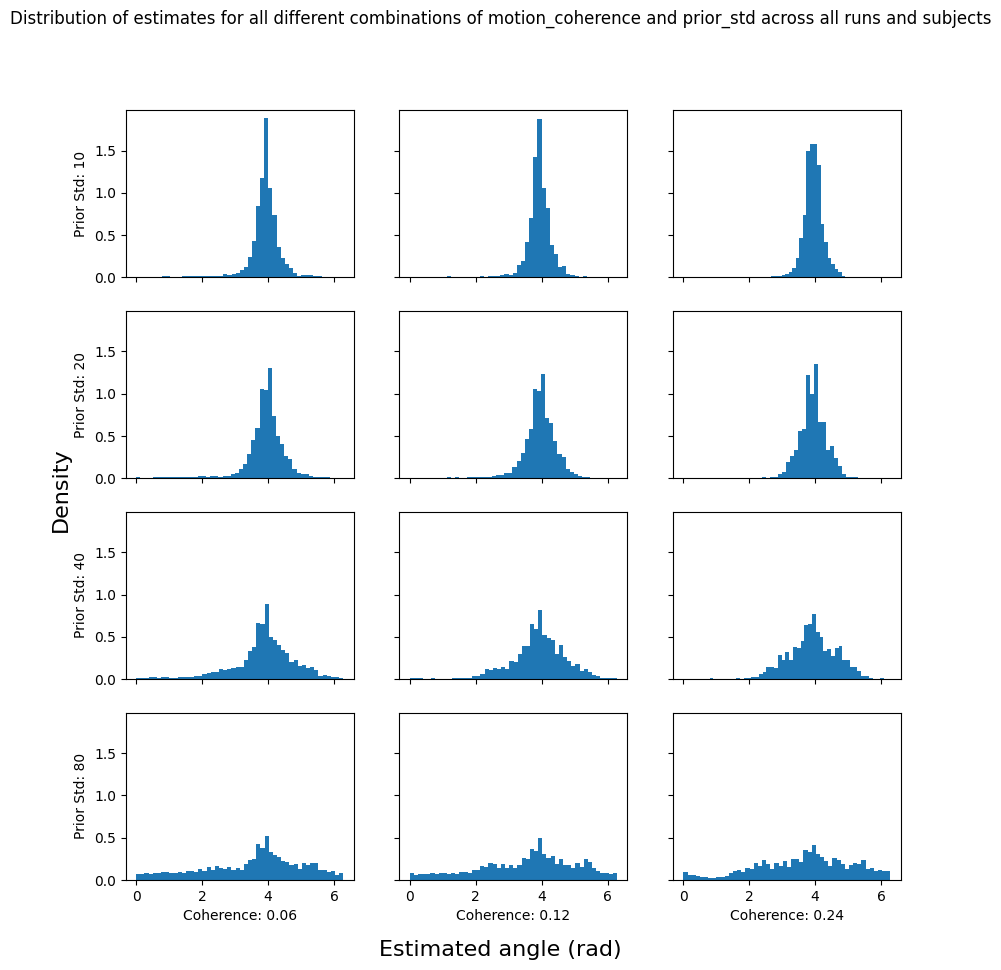

In [8]:
plot_histograms(
    data,
    "Estimated angle (rad)",
    "Density",
    "Distribution of estimates for all different combinations of motion_coherence and prior_std across all runs and subjects",
    sorted(data["motion_coherence"].unique()),
    sorted(data["prior_std"].unique()),
)

The results are as expected, although I would have expected the shapes to look more different for different values of coherence.

Now we drill down on a single subject and particular values of coherence and std and try to see if a simple Bayesian model can approximate the shape of the distribution of the subject's estimates.


In [9]:
# Create a grid of histograms (all with the same x and y axis scales) showing the distribution of estimates
# for all different combinations of motion_coherence and prior_std
def plot_histograms_for_subject(
    data, x_label, y_label, title, motion_coherence, prior_std
):
    """Plot histograms of estimates for all different combinations of motion_coherence and prior_std

    Args :
      data (pandas dataframe) - dataframe containing the data
      x_label (string) - label of x-axis
      y_label (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    # Plot estimate distributions for all different runs
    runs = sorted(
        data[
            (data["motion_coherence"] == motion_coherence)
            & (data["prior_std"] == prior_std)
        ]["run_id"].unique()
    )

    fig, axs = plt.subplots(
        len(runs),
        1,
        figsize=(10, 10),
        sharex=True,
        sharey=True,
    )

    for i, run in enumerate(runs):
        ax = axs[i]
        subject = data[
            (data["motion_coherence"] == motion_coherence)
            & (data["prior_std"] == prior_std)
            & (data["run_id"] == run)
        ]

        ax.hist(subject["estimate_angle_rad"], bins=50, density=True)
        ax.set_ylabel(f"Run: {run}")

    # Set common labels
    fig.text(0.5, 0.04, x_label, ha="center", va="center", fontsize=16)
    fig.text(
        0.06, 0.5, y_label, ha="center", va="center", rotation="vertical", fontsize=16
    )

    fig.suptitle(title)
    plt.show()
    return None

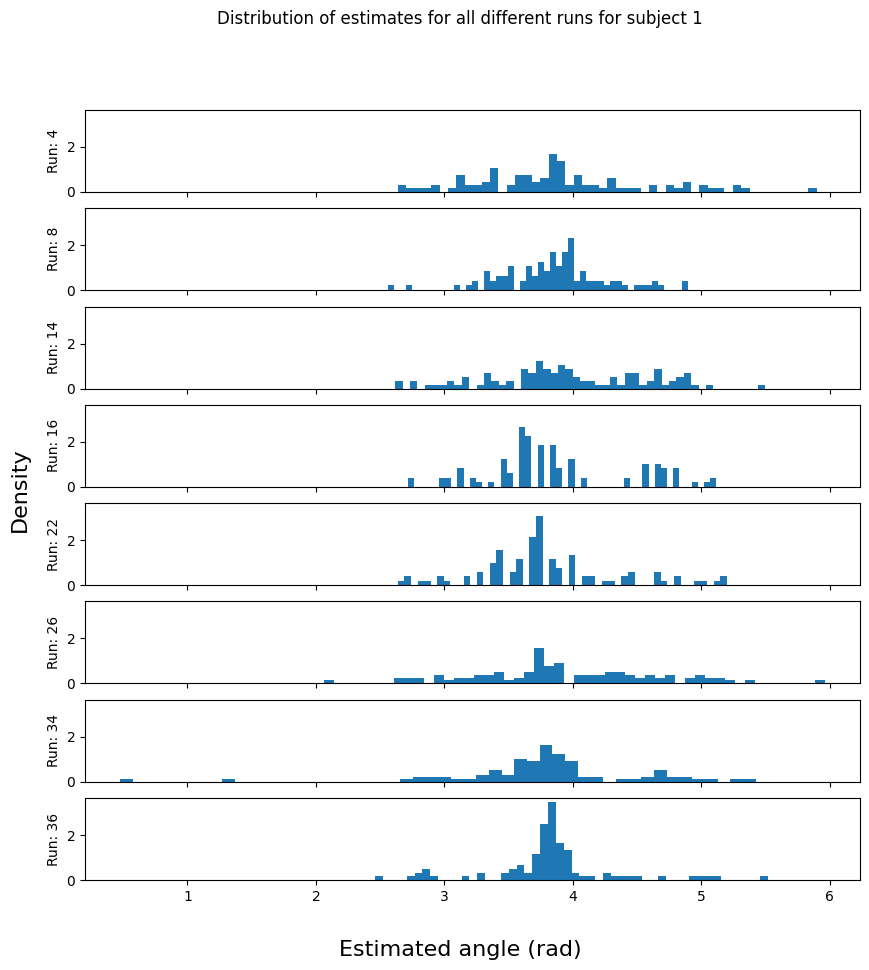

In [10]:
subject_id = 1
plot_histograms_for_subject(
    data[data["subject_id"] == subject_id],
    "Estimated angle (rad)",
    "Density",
    f"Distribution of estimates for all different runs for subject {subject_id}",
    motion_coherence=0.06,
    prior_std=40,
)

I think there's this.

So for one prior std and motion coherence.

There's roughly 36 different motion directions we can look at. We can try averaging these over subjects. To get one estimate distribution for each curve.

And then we create 36 bayesian curves as well and then adjust the prior std and motion coherence to create the best fit.
Either manually or programmatically?

Can we plot a curve or something like that for seeing the cost landscape of negative likelihood for different values of kappa?
And then see whether the minimal value is in face visually the best fit for all the data.


In [115]:
def generate_histograms_by_subject(data, motion_coherence, prior_std):
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)

    filtered_data = data[
        (data["motion_coherence"] == motion_coherence)
        & (data["prior_std"] == prior_std)
    ]

    bin_histograms = []
    for i in range(len(bins) - 1):
        subject_data = filtered_data[
            (data["motion_direction"] >= bins[i])
            & (data["motion_direction"] < bins[i + 1])
        ]
        # Get distribution for each subject and then average over subjects
        all_histograms = []

        # Group by subject and compute histogram for each subject
        grouped = subject_data.groupby("subject_id")

        for subject_id, group in grouped:
            adjusted = group["estimates_deg"] - 225
            hist, _ = np.histogram(adjusted, bins=50, density=True, range=(-160, 160))
            hist = np.nan_to_num(hist)
            all_histograms.append(hist)

        bin_histograms.append(np.mean(all_histograms, axis=0))

    return bin_histograms

In [116]:
binned_histograms = generate_histograms_by_subject(data, 0.06, 80)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2733369939.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2733369939.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2733369939.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2733369939.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000

In [118]:
def plot_binned_histograms(binned_histograms):
    bins = np.linspace(0, 360, 37)

    # For each interval, find all the motion directions that fall within that interval
    # and plot the histogram of estimated angles
    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(10, 50),
        sharex=True,
        sharey=True,
    )
    for i in range(len(bins) - 1):
        ax = axs[i]
        bin_edges = np.linspace(-160, 160, 51)  # 50 bins, so 51 edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(bin_centers, binned_histograms[i])

    fig.text(
        0.5,
        0.04,
        "Estimate directions relative to the prior mean (in degrees)",
        ha="center",
        va="center",
        fontsize=16,
    )
    fig.text(
        0.06,
        0.5,
        "Probability",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=16,
    )

    plt.show()

In [134]:
# Kappa_map
def plot_model_estimates(model, motion_coherence, prior_std):
    bins = np.linspace(0, 360, 37)

    # For each bin, we have theta_true
    model = BayesianModel(
        kappa_e=2.4,
        kappa_prior=1.22,
    )

    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(10, 50),
        sharex=True,
        sharey=True,
    )
    for i in range(len(bins) - 1):
        ax = axs[i]

        # Find the motion direction at the center of the bin interval
        theta_true = (bins[i] + bins[i + 1]) / 2
        # Convert to radians
        theta_true = get_deg_to_rad(theta_true, signed=False)
        dist = model.output(theta_true)
        # Convert to degrees
        dist = dist * 180 / pi
        dist = dist - 225

        bin_edges = np.linspace(-180, 180, 361)  # 50 bins, so 51 edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.plot(bin_centers, dist)

    fig.text(
        0.5,
        0.04,
        "Estimate directions relative to the prior mean (in degrees)",
        ha="center",
        va="center",
        fontsize=16,
    )
    fig.text(
        0.06,
        0.5,
        "Probability",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=16,
    )

    plt.show()

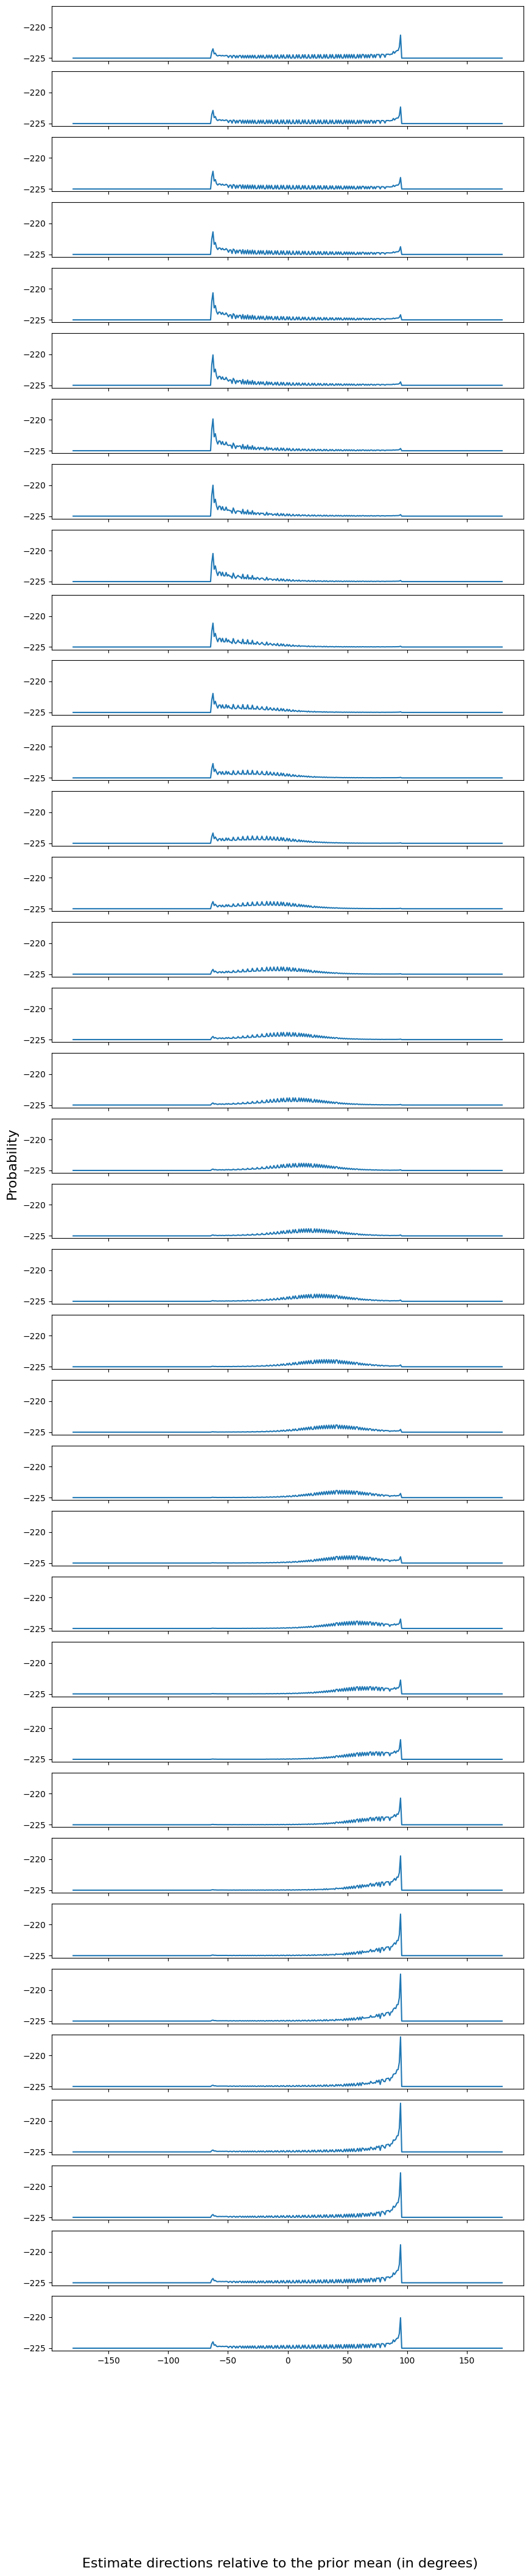

In [135]:
model = BayesianModel(
    kappa_e=2.4,
    kappa_prior=1.22,
)
plot_model_estimates(model, 0, 0)

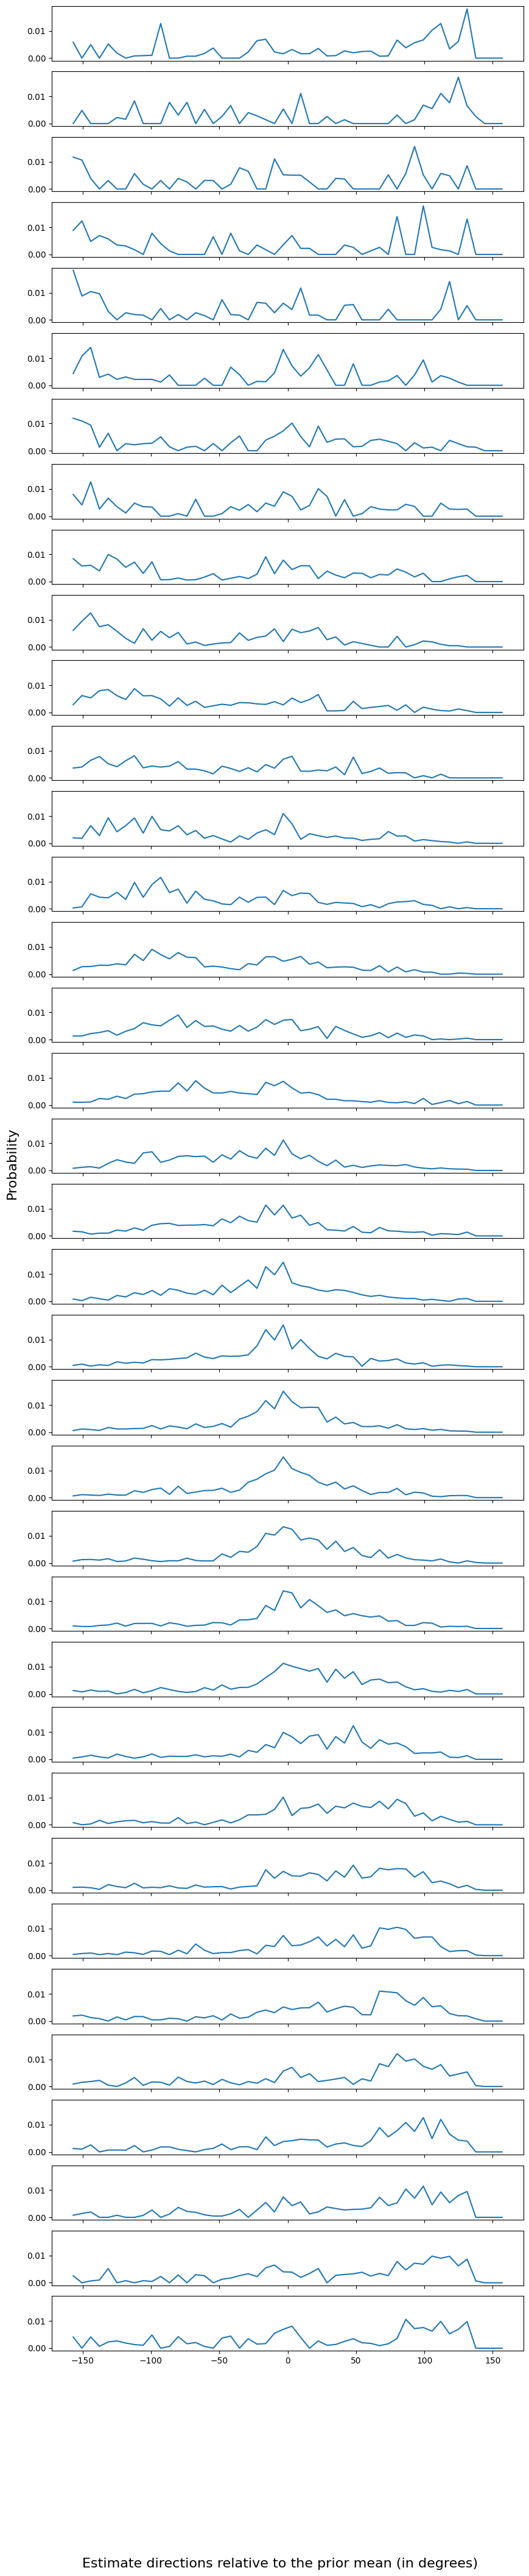

In [119]:
plot_binned_histograms(binned_histograms)

In [97]:
# Create a grid of histograms (all with the same x and y axis scales) showing the distribution of estimates
# for all different combinations of motion_coherence and prior_std
def plot_estimate_bins_across_subjects(
    data, x_label, y_label, title, motion_coherence, prior_std
):
    """Plot histograms of estimates for all different combinations of motion_coherence and prior_std

    Args :
      data (pandas dataframe) - dataframe containing the data
      x_label (string) - label of x-axis
      y_label (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)

    # For each interval, find all the motion directions that fall within that interval
    # and plot the histogram of estimated angles
    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(10, 50),
        sharex=True,
        sharey=True,
    )

    filtered_data = data[
        (data["motion_coherence"] == motion_coherence)
        & (data["prior_std"] == prior_std)
    ]

    for i in range(len(bins) - 1):
        ax = axs[i]

        subject_data = filtered_data[
            (data["motion_direction"] >= bins[i])
            & (data["motion_direction"] < bins[i + 1])
        ]
        # Get distribution for each subject and then average over subjects
        all_histograms = []

        # Group by subject and compute histogram for each subject
        grouped = subject_data.groupby("subject_id")

        for subject_id, group in grouped:
            adjusted = group["estimates_deg"] - 225
            hist, _ = np.histogram(adjusted, bins=50, density=True, range=(-160, 160))
            all_histograms.append(hist)

        # Average the histograms over all subjects
        if all_histograms:
            avg_hist = np.mean(all_histograms, axis=0)

            # Ensure there are no NaN values in avg_hist
            # if np.isnan(avg_hist).any() or np.isinf(avg_hist).any():
            #     avg_hist = np.nan_to_num(avg_hist)
            bin_edges = np.linspace(-160, 160, 51)  # 50 bins, so 51 edges
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax.plot(bin_centers, avg_hist)

    # Set common labels
    fig.text(0.5, 0.04, x_label, ha="center", va="center", fontsize=16)
    # fig.text(
    #     0.06, 0.5, y_label, ha="center", va="center", rotation="vertical", fontsize=16
    # )

    fig.suptitle(title)
    plt.show()

    return None

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/790546574.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/790546574.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/790546574.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/790546574.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject_data = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T

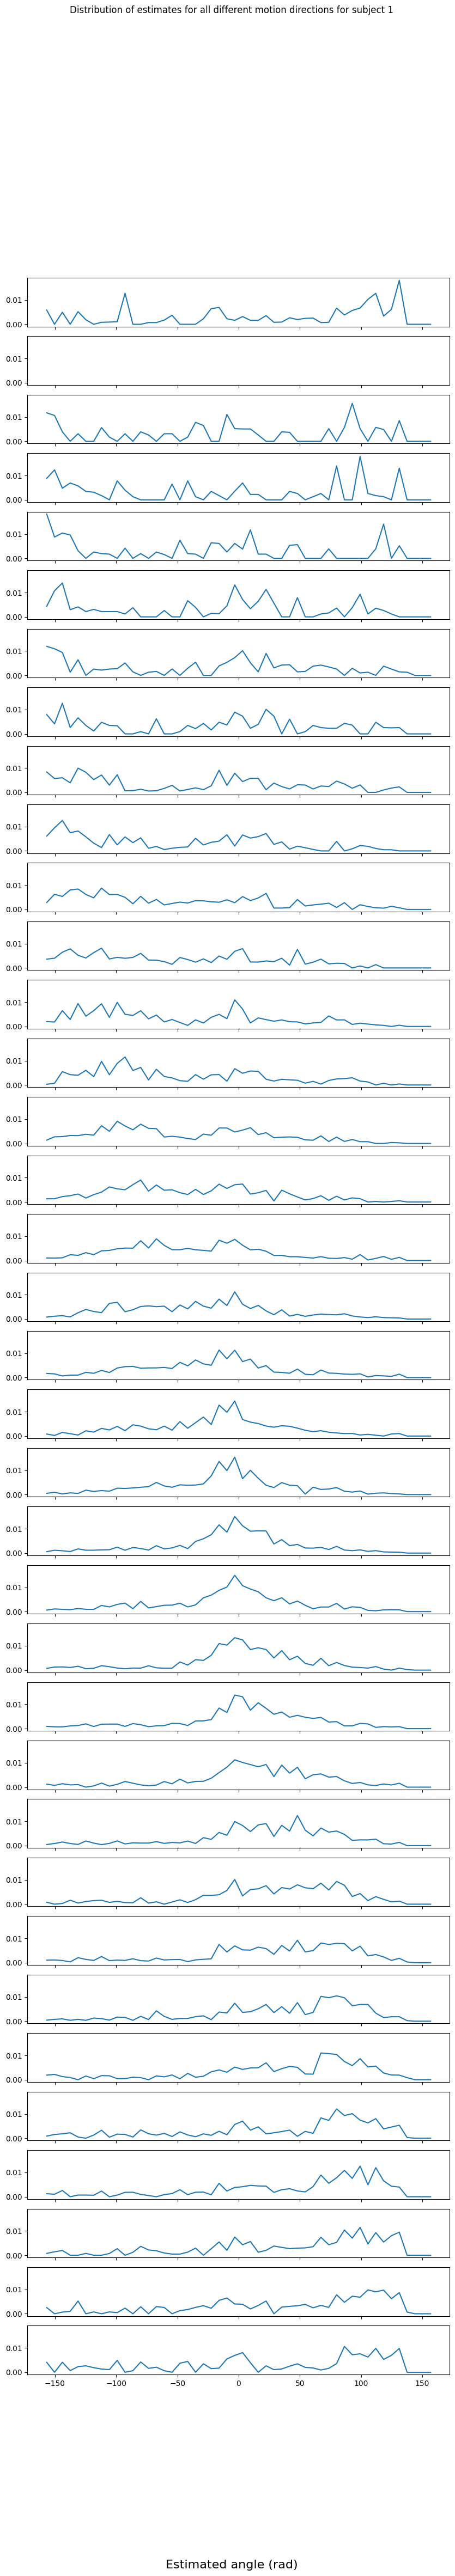

In [98]:
plot_estimate_bins_across_subjects(
    data,
    "Estimated angle (rad)",
    "Density",
    "Distribution of estimates for all different motion directions for subject 1",
    motion_coherence=0.06,
    prior_std=80,
)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/3701916927.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[


<Axes: >

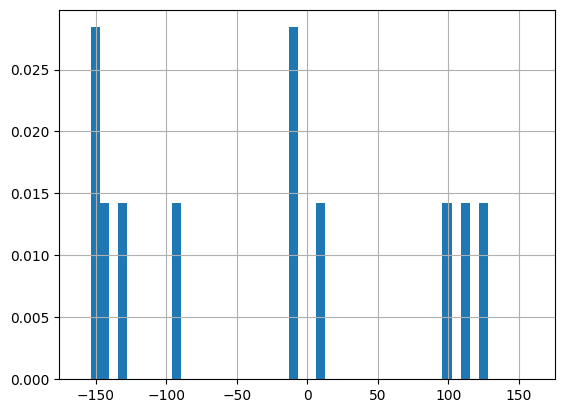

In [62]:
motion_coherence = 0.06
prior_std = 80

bins = np.linspace(0, 360, 37)

filtered_data = data[
    (data["motion_coherence"] == motion_coherence)
    & (data["prior_std"] == prior_std)
    & (data["subject_id"] == subject_id)
]

# for i in range(len(bins) - 1):
subject = filtered_data[
    (data["motion_direction"] >= bins[5]) & (data["motion_direction"] < bins[5 + 1])
]

adjusted = subject["estimates_deg"] - 225
adjusted.hist(bins=50, density=True, range=(-160, 160))

In [69]:
# Create a grid of histograms (all with the same x and y axis scales) showing the distribution of estimates
# for all different combinations of motion_coherence and prior_std
def plot_estimate_bins(
    data, x_label, y_label, title, motion_coherence, prior_std, subject_id
):
    """Plot histograms of estimates for all different combinations of motion_coherence and prior_std

    Args :
      data (pandas dataframe) - dataframe containing the data
      x_label (string) - label of x-axis
      y_label (string) - label of y-axis
      title  (string) - title of plot

    Returns:
      None
    """
    # Split estimated angles into 10 degree bins for a total of 36 bins
    bins = np.linspace(0, 360, 37)

    # For each interval, find all the motion directions that fall within that interval
    # and plot the histogram of estimated angles
    fig, axs = plt.subplots(
        len(bins) - 1,
        1,
        figsize=(10, 30),
        sharex=True,
        sharey=True,
    )

    filtered_data = data[
        (data["motion_coherence"] == motion_coherence)
        & (data["prior_std"] == prior_std)
        & (data["subject_id"] == subject_id)
    ]

    for i in range(len(bins) - 1):
        ax = axs[i]
        subject = filtered_data[
            (data["motion_direction"] >= bins[i])
            & (data["motion_direction"] < bins[i + 1])
        ]

        adjusted = subject["estimates_deg"] - 225
        ax.hist(adjusted, bins=50, density=True, range=(-160, 160))

    # Set common labels
    fig.text(0.5, 0.04, x_label, ha="center", va="center", fontsize=16)
    # fig.text(
    #     0.06, 0.5, y_label, ha="center", va="center", rotation="vertical", fontsize=16
    # )

    fig.suptitle(title)
    plt.show()

    return None

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/3779819116.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/3779819116.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/3779819116.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/3779819116.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103

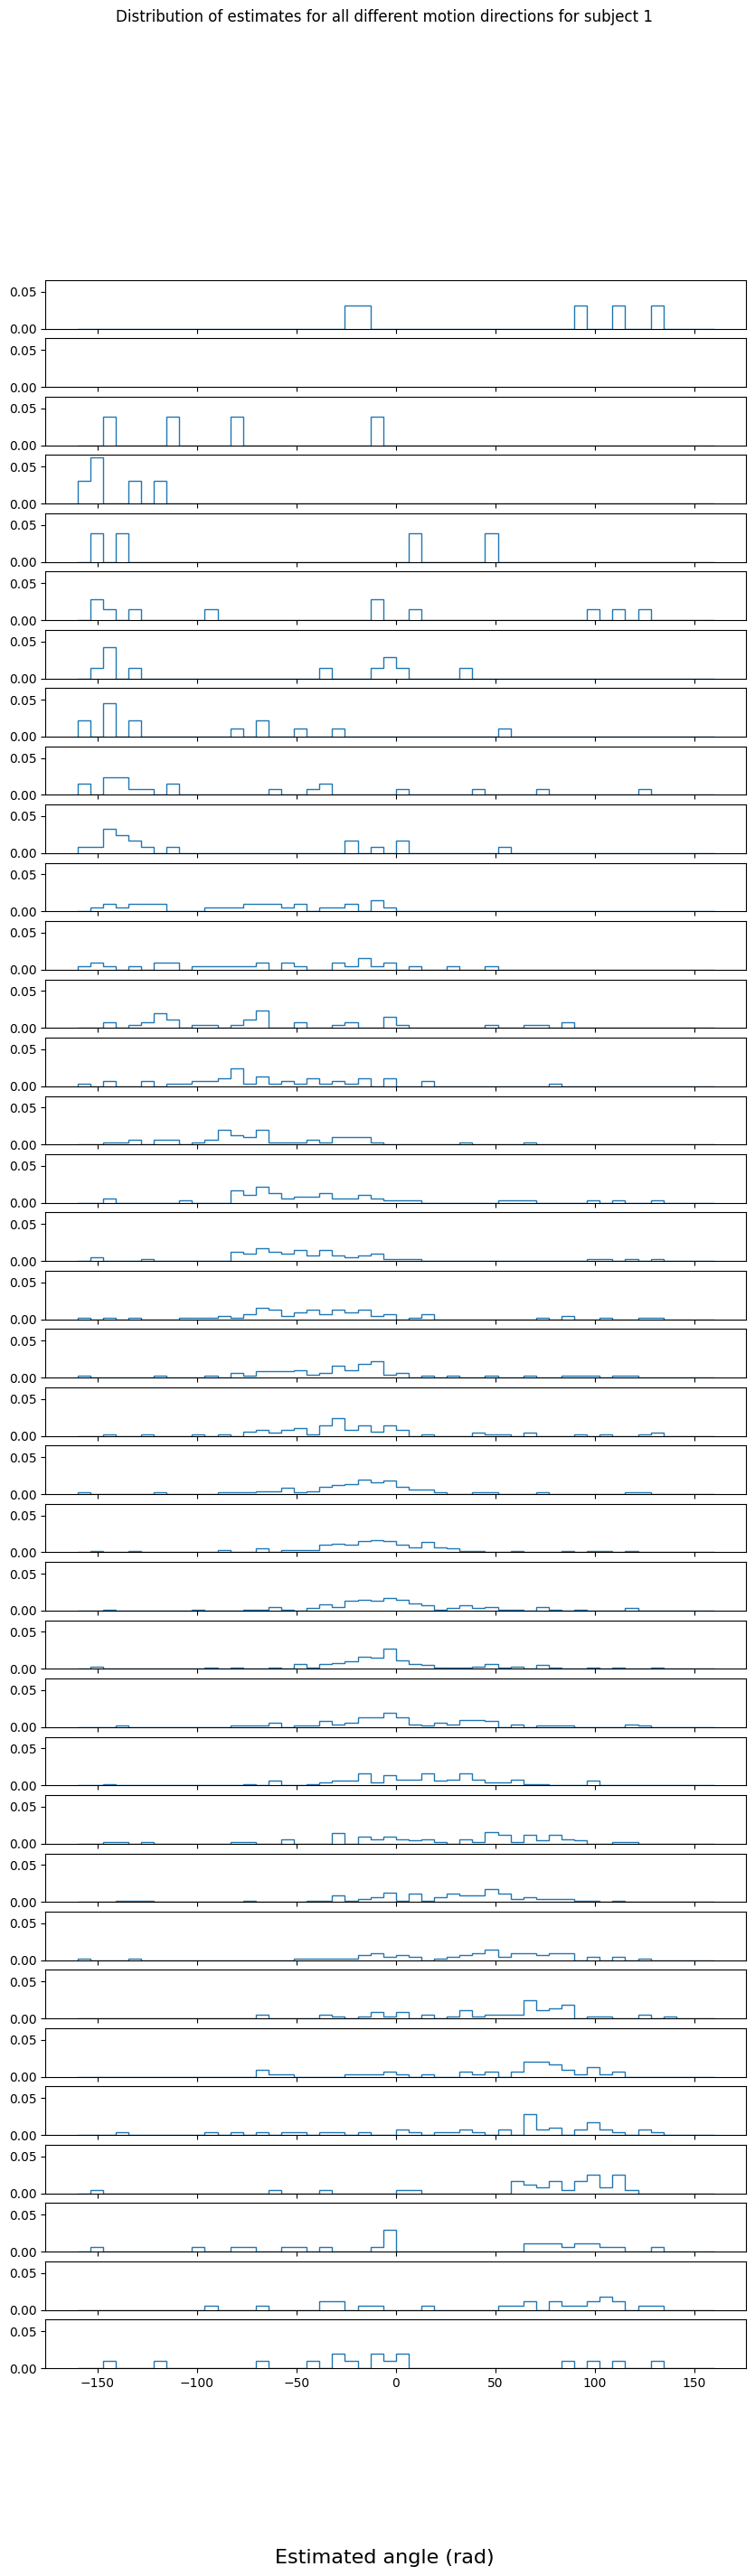

In [68]:
plot_estimate_bins(
    data,
    "Estimated angle (rad)",
    "Density",
    "Distribution of estimates for all different motion directions for subject 1",
    motion_coherence=0.06,
    prior_std=80,
    subject_id=1,
)

/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2690483576.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2690483576.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_73103/2690483576.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subject = filtered_data[
/Users/kimyoungjin/Desktop/neuromatch/venv/lib/python3.12/

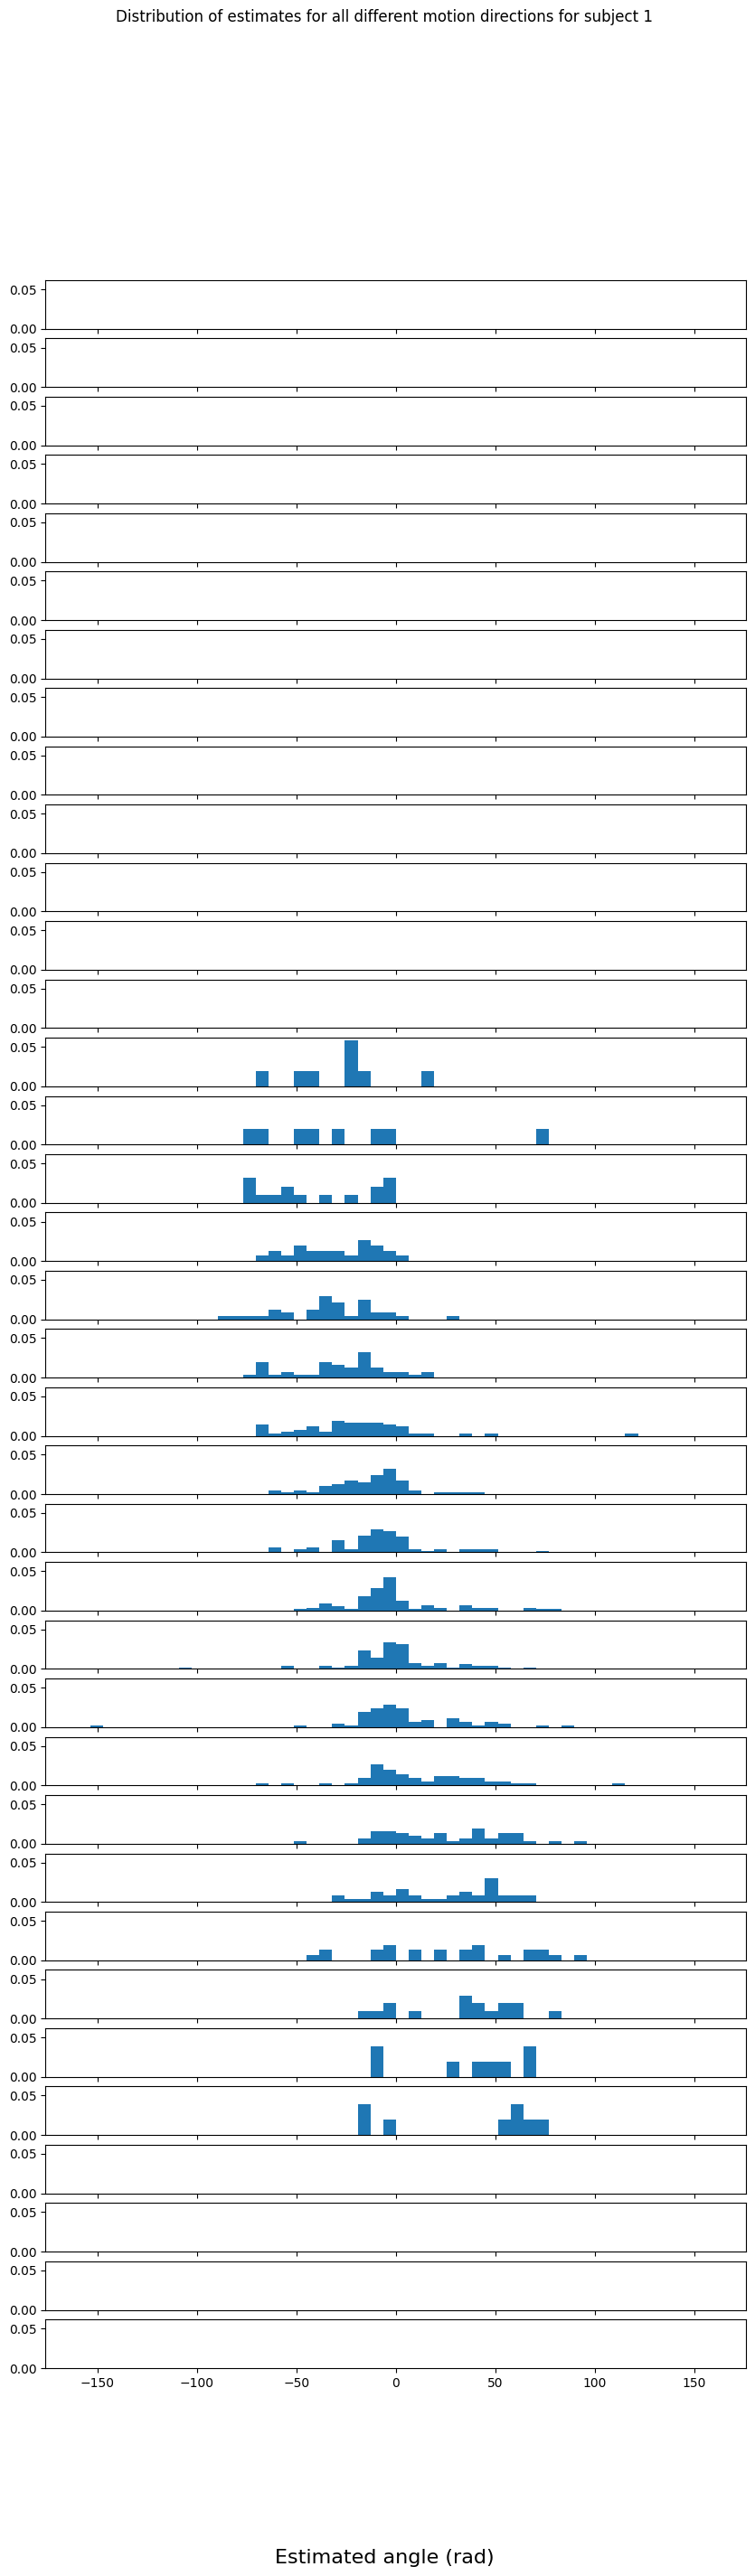

In [70]:
plot_estimate_bins(
    data,
    "Estimated angle (rad)",
    "Density",
    "Distribution of estimates for all different motion directions for subject 1",
    motion_coherence=0.06,
    prior_std=40,
    subject_id=1,
)

Ok, now try to actually fit the basic observer model to these.
We "train" the basic bayesian on just 2 parameters, the kappa_e and the kappa_p because we are restricting to only one set of prior_std and coherence. (Here we can create the simple visualization to try "fitting" the model ourselves).

Let's try creating a distribution using arbitrary values for now.

---

How can we **visually** see the fitting to the data?
For each subject, we have estimate distribution for multiple prior std and coherence.
We also have estimate distribution by run.

Well, since the 9 parameters are unable to differentiate across runs,
We need to understand that for a fixed std and coherence, model simply means a single pair of kappas as input to produce our priors, likelihoods, etc.

To see the actual fit visually, maybe we can
For each run of particular


Ok, sorry I just really need to understand exactly how the paper compared the model estimates to the subject estimates.


### Intuition behind paper's Bayesian modelling

For each trial, we have the following components of the subject's internal "model" of the world.

1. The prior distribution. This is the distribution of "hypothesized" states which we simply assume is like the true distribution of angles around the mean.
2. The likelihood distribution. Probability of them having the particular theta percept given a hypothesized theta. This can be treated as a 2-input function, with a distribution forming over every value of possible theta_hyp. From the experimenter's point of view, I do not know the subject's theta_hyp, nor do I know his theta_e. All I know is the true theta, around which a theta_e distribution can be formed.
3. Finally we can multiply prior and likelihood to get the posterior distribution. We need to normalize this by dividing each new column by the sum of probabilities down that column.

What we have now is a probability distribution of theta_e for each possible theta_hyp. We do not know theta_hyp. But we can calculate percepted theta by taking the argmax of the theta_e for each theta_hyp.

Then we need to calculate the distribution of percepts GIVEN a theta_true.
We can do this by finding the distribution of theta_e given a particular theta_true.

For each particular theta*hyp, we have a max theta_e which is our theta_percept. Then from the distribution just now we also know the \_probability* of this theta_e occurring.


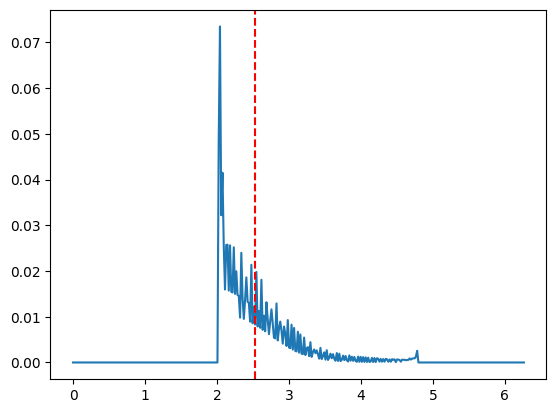

In [75]:
# Literally just input kappa_e and kappa_p, and get a percept distribution back
model = BayesianModel(
    kappa_e=2.4,
    kappa_prior=1.22,
)
dist = model.output(pi / 2)
plt.plot(model.theta_range, dist)

# Find the mean and put it in the figure
mean = np.sum(dist * model.theta_range)
plt.axvline(mean, color="red", linestyle="--")

Filter data so that we can just focus on one subject's responses for the lowest coherence value and lowest standard deviation.

What I want to do is to maybe create a visualization I can interact with where I can change the different values and kind of try to fit it to the actual data as best as possible.
Then compare the final values we get from automated optimization.


In [27]:
data["motion_coherence"].unique()

array([0.12, 0.06, 0.24])

In [29]:
data["prior_std"].unique()

array([10, 80, 20, 40])

In [36]:
motion_coherence = 0.24
prior_std = 80

In [37]:
subject_1 = data[
    (data["subject_id"] == 1)
    & (data["motion_coherence"] == motion_coherence)
    & (data["prior_std"] == prior_std)
]

In [124]:
class BayesianModel:
    def __init__(self, kappa_e, kappa_prior):
        self.kappa_e = kappa_e
        self.kappa_prior = kappa_prior

        # Mean is 225 in radians
        self.prior_mean = get_deg_to_rad(225, False)
        self.theta_range = np.linspace(0, 2 * pi, 360, endpoint=False)

        likelihood = self.likelihood_array(self.theta_range, self.theta_range, kappa_e)
        prior = self.prior_array(
            self.theta_range, self.theta_range, self.prior_mean, kappa_prior
        )
        posterior = self.posterior_array(prior, likelihood)
        binary_decision = self.binary_decision_array(self.theta_range, posterior)
        self.binary_decision = binary_decision

    def likelihood_array(self, x_points, stim_array, kappa_e):
        # initializing likelihood_array
        likelihood_array = np.zeros((len(stim_array), len(x_points)))
        # looping over stimulus array

        for i in range(len(x_points)):
            likelihood_array[:, i] = vonmises.pdf(
                stim_array, kappa=kappa_e, loc=x_points[i]
            )

        return likelihood_array

    def prior_array(self, x_points, stim_array, mean, kappa):
        prior = vonmises.pdf(x_points, kappa=kappa, loc=mean)

        prior_array = np.tile(prior, len(stim_array)).reshape(len(stim_array), -1)

        return prior_array

    def posterior_array(self, prior_array, likelihood_array):
        posterior_array = prior_array * likelihood_array
        posterior_array /= posterior_array.sum(axis=1, keepdims=True)

        return posterior_array

    def binary_decision_array(self, x_points, posterior_array):
        binary_decision_array = np.zeros_like(posterior_array)

        for i in range(len(posterior_array)):
            mean = np.sum(x_points * posterior_array[i])

            # find the position of mean in x_points (closest position)
            idx = np.argmin(np.abs(x_points - mean))
            # set the cell of the binary decision array to 1
            binary_decision_array[i, idx] = 1

        return binary_decision_array

    def generate_input_array(self, x_points, stim_array, mean, kappa):
        vonmises_values = vonmises.pdf(stim_array[:, None], kappa=kappa, loc=mean)
        input_array = np.tile(vonmises_values, (1, len(x_points)))

        return input_array

    def percept_distribution(self, input_array, binary_decision_array):
        marginalization_array = input_array * binary_decision_array
        marginal = np.sum(marginalization_array, axis=0)
        marginal /= np.sum(marginal)

        return marginalization_array, marginal

    # Given a true theta value, return a distribution of
    def output(self, theta_true):
        input_array = self.generate_input_array(
            self.theta_range,
            self.theta_range,
            mean=theta_true,
            kappa=self.kappa_e,
        )
        _, estimate_dist = self.percept_distribution(input_array, self.binary_decision)
        return estimate_dist

    def log_likelihood(self, params, data):
        (
            self.kappa_e,
            self.kappa_prior,
        ) = params
        log_prob = 0
        count = 0
        for theta_true, theta_est, coherence, prior_std in data:
            count += 1

            # We fit to subject estimates
            # likelihood = self.likelihood_array(
            #     self.theta_range, self.theta_range, self.get_kappa_e(coherence)
            # )
            # prior = self.prior_array(
            #     self.theta_range,
            #     self.theta_range,
            #     self.prior_mean,
            #     self.get_kappa_prior(prior_std),
            # )
            # posterior = self.posterior_array(prior, likelihood)
            # binary_decision = self.binary_decision_array(self.theta_range, posterior)
            input_array = self.generate_input_array(
                self.theta_range,
                self.theta_range,
                # posterior,
                self.binary_decision,
                theta_true,
                self.get_kappa_e(coherence),
            )
            _, estimate_dist = self.percept_distribution(
                input_array, self.binary_decision
            )

            # Find the bin corresponding to theta_est
            est_bin = int(np.round(theta_est / (2 * np.pi) * 360)) % 360
            log_prob += np.log(
                estimate_dist[est_bin] + 1e-10
            )  # Add small constant to avoid log(0)

        return -log_prob  # Return negative log-likelihood for minimization

    def fit(self, data):
        # Initial parameter guesses
        # initial_params = [1.0, 2.0, 3.0, 0.5, 1.0, 1.5, 2.0, 1.0, 0.1]
        # initial_params = [1.0, 2.0, 3.0, 0.5, 1.0, 1.5, 2.0]
        initial_params = [1.0, 2.0]

        bounds = [(0, None), (0, None)]

        # Fit the model using maximum likelihood estimation
        result = minimize(
            self.log_likelihood,
            initial_params,
            args=(data,),
            method="Nelder-Mead",
            bounds=bounds,
        )

        (
            self.kappa_e_low,
            # self.kappa_e_med,
            # self.kappa_e_high,
            self.kappa_prior_low,
            # self.kappa_prior_med,
            # self.kappa_prior_high,
            # self.kappa_prior_high_coh,
            # self.kappa_m,
            # self.p_r,
        ) = result.x
        return result.x

    def train(self, df):
        data_for_model = list(
            zip(
                df["motion_direction_rad"],
                df["estimate_angle_rad"],
                df["motion_coherence"],
                df["prior_std"],
            )
        )
        return self.fit(data_for_model)

In [129]:
model = BayesianModel(
    kappa_e=2.4,
    kappa_prior=1.22,
)
model.output(pi / 2)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2827566319.py:13: SyntaxWarning: invalid escape sequence '\~'
  "Possible brain encoding $\~x$",
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/2827566319.py:14: SyntaxWarning: invalid escape sequence '\~'
  "Likelihood as a function of $\~x$ : $p(\~x | x)$",


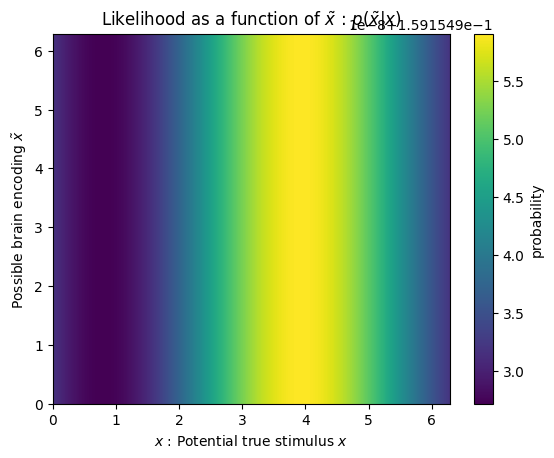

In [129]:
model = BayesianModel()
likelihood = model.likelihood_array(model.theta_range, model.theta_range, kappa_e_low)
prior = model.prior_array(
    model.theta_range, model.theta_range, model.prior_mean, 0.0000001
)
# prior= calculate_prior_array(
#     theta_hyp_array, theta_evidence_array, mean=get_deg_to_rad(225, False), kappa=2
# )

plot_myarray(
    prior,
    "$x$ : Potential true stimulus $x$",
    "Possible brain encoding $\~x$",
    "Likelihood as a function of $\~x$ : $p(\~x | x)$",
)

In [136]:
# Create probability distribution of percepts and also create probability distribution of actual
# User responses so that we can compare


def plot_percept_distribution(
    model, coherence, prior_std, kappa_e, kappa_prior, theta_true
):
    likelihood = model.likelihood_array(model.theta_range, model.theta_range, kappa_e)
    prior = model.prior_array(
        model.theta_range, model.theta_range, model.prior_mean, kappa_prior
    )
    posterior = model.posterior_array(prior, likelihood)
    binary_decision = model.binary_decision_array(model.theta_range, posterior)
    input_array = model.generate_input_array(
        model.theta_range, model.theta_range, binary_decision, theta_true, kappa_e
    )
    _, estimate_dist = model.percept_distribution(input_array, binary_decision)

    plt.figure()
    plt.plot(model.theta_range, estimate_dist)
    plt.xlabel("Estimated $\hat x$")
    plt.ylabel("Probability")
    plt.title("Probability distribution of percepts")
    plt.show()

    return estimate_dist

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
/var/folders/q4/2lsmb6qd1ks8137720rg8fz80000gn/T/ipykernel_3175/3935883572.py:19: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("Estimated $\hat x$")


In [125]:
model = BayesianModel()
plot_percept_distribution(
    model,
    0.06,
    10,
    kappa_e_low,
    kappa_prior_low,
)

TypeError: BayesianModel.__init__() missing 2 required positional arguments: 'kappa_e' and 'kappa_prior'

In [51]:
int(np.round(0.3211406 / (2 * np.pi) * 360)) % 360

18

In [50]:
data["motion_coherence"].unique()

array([0.12, 0.06, 0.24])

In [68]:
def objective_function(x):
    return (x - 3) ** 2


x0 = 0  # Initial guess

In [69]:
result = minimize(objective_function, x0, method="BFGS")
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5388963550532293e-16
        x: [ 3.000e+00]
      nit: 2
      jac: [-1.697e-08]
 hess_inv: [[ 5.000e-01]]
     nfev: 6
     njev: 3

We can try reducing the problem down to its bare bones.
Just focus on one coherence and one standard deviation.
Then compare the shapes of the learnt outputs.
